In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm


In [122]:
im1_mean = [0.4042127201928427, 0.412576527722026, 0.42259604676925305, 0.43350413711051056, 0.443855690032959, 0.45140969585826785, 0.45334100553503703, 0.4468871853247354, 0.43043786530179756, 0.404718756014092, 0.37331931684981945, 0.3418279141576013,0.31582148226006085]
im2_mean = [0.41915108148831637, 0.42160734423110063, 0.423962258067611, 0.42601487354034223, 0.4275087523492551, 0.4281458628877129, 0.4276228290175893, 0.4257433505811504, 0.4224049007987228, 0.41766727063885856, 0.411706916417739, 0.4048067182780746,0.39733730345961626]
im3_mean = [0.44033469101140527, 0.4503952708250446, 0.46193364562084055, 0.4738397130390685, 0.48420565326379844, 0.49040465635549285, 0.48956380687421636, 0.47946231783341775, 0.45967343462004484, 0.4323601088249301, 0.4019184607310354, 0.37350198569667487,0.3512268327779888]

im1_std = [0.14732023241999434, 0.147809241675677, 0.14804508827283613, 0.1477574222750175, 0.1470682801149269, 0.146539035212084, 0.14675348492637386, 0.14775991989824996, 0.14848621292810835, 0.1465088569090591, 0.13925408874284476, 0.12590440973744257,0.10823487264730804]
im2_std = [0.12246606074712985, 0.12329658876446659, 0.1242021620079717, 0.12510900974078862, 0.12595538841389356, 0.12670439991891755, 0.12730158828399146, 0.12765988385551708, 0.12760264169433708, 0.1269505535408886, 0.12552824561659184, 0.12318955457930125,0.11984089703152391]
im3_std = [0.11690682253979083, 0.11736897240085645, 0.11786639327518504, 0.11859482672002022, 0.11987161521520828, 0.1221401983344635, 0.12578272075012656, 0.13025746011922526, 0.13357738663561808, 0.13312490121042017, 0.12725185198165137, 0.11619303606414197,0.10181700640611481]

calibrator1 = {}
calibrator2 = {}

for i in range(13):
    layer_idx = i
    def calibration1(layer_data,layer_idx):
        mask = (layer_data >= 0.1) & (layer_data <= 0.9) 
        scaled_x = np.copy(layer_data)  
        scaled_x[mask] = ((layer_data[mask] - im2_mean[layer_idx])/im2_std[layer_idx]) * im1_std[layer_idx] + im1_mean[layer_idx] 
        return scaled_x
    
    def calibration2(layer_data,layer_idx):
        mask = (layer_data >= 0.1) & (layer_data <= 0.9) 
        scaled_x = np.copy(layer_data)  
        scaled_x[mask] = ((layer_data[mask] - im3_mean[layer_idx])/im3_std[layer_idx]) * im1_std[layer_idx] + im1_mean[layer_idx] 
        return scaled_x    

    calibrator1[layer_idx] = calibration1
    calibrator2[layer_idx] = calibration2
    
    

In [110]:
import numba
import numpy as np
from PIL import Image
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from typing import Tuple, List
from torchvision.transforms import transforms
import cv2

class VesuviusTrainData(Dataset):
    _relative_sv_dir = "surface_volume"  # relative to the directory of train data

    def __init__(self,
                 dir_path: str = "train/1",
                 z_start: int = 0,
                 z_end: int = 64,
                 nucleus_shape: Tuple[int, int] = (16, 16),
                 hull_size: Tuple[int, int] = (64, 64),
                 compress_depth =  None,
                 give_indx = False,
                 calibrator = None,
                 boundarysize = None
                 ):
        self.dir_path = dir_path

        self.z_start = z_start
        self.z_end = z_end

        self.nucleus_shape = nucleus_shape
        self.hull_size = hull_size
        
        self.compress_depth = compress_depth
        self.give_indx = give_indx
        self.calibrator = calibrator
        self.boundarysize = boundarysize
        
        
        self._setup()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index: int):
        i, j = self._get_pixel_from_index(self.indices[index])
        nucleus_height, nucleus_width = self.nucleus_shape

        if self.give_indx == False:
            if self.calibrator != None:
                return (torch.from_numpy(
                    self.calibrate(self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ])),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height]))
            else:
                return (torch.from_numpy(
                    self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ]),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height])) 
        else:
            if self.calibrator != None:
                return (torch.from_numpy(
                    self.calibrate(self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ])),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height]),
                   np.stack(([i+k for k in range(nucleus_width)],[
                    j+k for k in range(nucleus_height)]),axis=1))
            else:
                return (torch.from_numpy(
                    self.images[
                    :,
                    i - self._left_hull + self._left_pad_image:
                    i + nucleus_width + self._right_hull + self._left_pad_image,
                    j - self._top_hull + self._top_pad_image:
                    j + nucleus_height + self._bottom_hull + self._top_pad_image
                     ]),
                    torch.from_numpy(
                    self.inklabels[i: i + nucleus_width,
                    j: j + nucleus_height]),
                   np.stack(([i+k for k in range(nucleus_width)],[
                    j+k for k in range(nucleus_height)]),axis=1)) 
            
    def calibrate(self,arr):
        calibrated_arr = np.zeros_like(arr)

        for i in range(arr.shape[0]):
            calibration_func = self.calibrator[i]
            calibrated_arr[i, :, :] = calibration_func(arr[i, :, :],i)
        return calibrated_arr


    def _load_images(self, z_start=None,z_end=None):
        if z_end is None:
            z_end = self.z_end 
        if z_start is None:
            z_start = self.z_start
            
        num_images = z_end - z_start
        self.images = np.empty(
            (
                num_images,
                self.mask.shape[0] + self._left_pad_image + self._right_pad_image,
                self.mask.shape[1] + self._top_pad_image + self._bottom_pad_image
            ), 
            dtype=np.float16
        )
        for index, i in enumerate(range(z_start, z_end)):
            # noinspection PyTypeChecker
            image = np.array(Image.open(f"{self.dir_path}"
                                        f"/{self._relative_sv_dir}"
                                        f"/{i:02d}.tif"),
                             dtype=np.float32) / 65535.0
            
            image = image.astype(np.float16)
            
            image = np.pad(image, ((self._left_pad_mask + self._left_pad_image,
                                    self._right_pad_mask + self._right_pad_image),
                                   (self._top_pad_mask + self._top_pad_image,
                                    self._bottom_pad_mask + self._bottom_pad_image)),
                           'constant', constant_values=0)
            self.images[index, :, :] = image
            
    def _load_scale(self):
        current_stack_layer = self.z_start
        images = np.empty(
            (
                len(self.compress_depth),
                self.mask.shape[0] + self._left_pad_image + self._right_pad_image,
                self.mask.shape[1] + self._top_pad_image + self._bottom_pad_image
            ), 
            dtype=np.float16
        )
        for index,layer in enumerate(self.compress_depth):
            self._load_images(current_stack_layer, current_stack_layer + layer)
            current_stack_layer += layer
            layer_stack = self.images
            images[index,:,:] = np.mean(layer_stack,axis = 0)
            
        self.images = images
        
        
    def crop_boundary(self,mask, boundary_size):
        mask = mask.astype(np.uint8)
        mask_binary = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]

        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        boundary_mask = np.ones_like(mask, dtype=np.uint8)

        cv2.drawContours(boundary_mask, contours, -1, (0), 100)

        kernel_size = int(boundary_size)  # Adjust the kernel size based on your needs
        kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        eroded_boundary_mask = cv2.erode(boundary_mask, kernel, iterations=1)

        cropped_mask = mask * eroded_boundary_mask[:, :]

        return cropped_mask
    
    # Internal utility methods
    def _setup(self):
        # noinspection PyTypeChecker
        self.mask = np.array(Image.open(f"{self.dir_path}/mask.png"))
        if (self.boundarysize) != None:
            self.mask = self.crop_boundary(self.mask,self.boundarysize)
        # noinspection PyTypeChecker
        self.inklabels = np.array(Image.open(f"{self.dir_path}/inklabels.png"))
        self._granulate_mask()
        self._fill_new_mask()
        if self.compress_depth is None:
            self._load_images()
        else:
            self._load_scale()
        self._get_leftover_hull()

    def _granulate_mask(self):
        self._get_paddings()
        self.mask = np.pad(self.mask,
                           ((self._left_pad_mask, self._right_pad_mask),
                            (self._top_pad_mask, self._bottom_pad_mask)),
                           'constant', constant_values=0)
        self.indices = _find_labeled_nucleus(self.mask, self.nucleus_shape)
        self.inklabels = np.pad(self.inklabels, 
                                ((self._left_pad_mask, self._right_pad_mask),
                                 (self._top_pad_mask, self._bottom_pad_mask)),
                                'constant', 
                                constant_values=0)

    def _get_paddings(self):
        width, height = self.mask.shape
        nucleus_width, nucleus_height = self.nucleus_shape
        hull_width, hull_height = self.hull_size
        self._left_pad_mask = (width % nucleus_width) // 2
        self._right_pad_mask = width % nucleus_width - self._left_pad_mask
        self._top_pad_mask = (height % nucleus_height) // 2
        self._bottom_pad_mask = height % nucleus_height - self._top_pad_mask

        self._left_pad_image = (hull_width - nucleus_width) // 2
        self._right_pad_image = hull_width - nucleus_width - self._left_pad_image
        self._top_pad_image = (hull_height - nucleus_height) // 2
        self._bottom_pad_image = hull_height - nucleus_height - self._top_pad_image

    def _fill_new_mask(self):
        nucleus_width, nucleus_height = self.nucleus_shape
        self.mask = np.zeros_like(self.mask)
        for index in self.indices:
            i, j = self._get_pixel_from_index(index)
            self.mask[
                i * nucleus_width: (i + 1) * nucleus_width,
                j * nucleus_height: (j + 1) * nucleus_height
            ] = 1

    def _get_pixel_from_index(self, index: int):
        mask_width, mask_height = self.mask.shape
        nucleus_width, nucleus_height = self.nucleus_shape
        height = mask_height // nucleus_height
        return index // height * nucleus_height, index % height * nucleus_width

    def _get_leftover_hull(self):
        nucleus_width, nucleus_height = self.nucleus_shape
        hull_width, hull_height = self.hull_size
        self._left_hull = (hull_width - nucleus_width) // 2
        self._right_hull = hull_width - nucleus_width - self._left_hull
        self._top_hull = (hull_height - nucleus_height) // 2
        self._bottom_hull = hull_height - nucleus_height - self._top_hull


@numba.njit()
def _find_labeled_nucleus(mask, nuclues_shape):
    width, height = mask.shape
    nucleus_width, nucleus_height = nuclues_shape

    indices = - np.ones((width // nucleus_width) * (height // nucleus_height), dtype=np.int32)
    current_index = 0
    for i in range(width // nucleus_width):
        for j in range(height // nucleus_height):
            if np.sum(
                    mask[i * nucleus_width: (i + 1) * nucleus_width,
                         j * nucleus_height: (j + 1) * nucleus_height]
                      ) > 0:
                indices[current_index] = i * (height // nucleus_height) + j
                current_index += 1
    return indices[indices != -1]

# Preprocessing

In [66]:
data1 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/1"\
    ,nucleus_shape = (500,500),hull_size=(500,500), z_start=22
    , z_end=35,boundarysize=900,give_indx = True)

In [123]:
data2 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/2"\
    ,nucleus_shape = (500,500),hull_size=(500,500), z_start=22\
    , z_end=35,boundarysize=1200,give_indx=True,calibrator=calibrator1)

In [124]:
data3 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/3"\
    ,nucleus_shape = (500,500),hull_size=(500,500), z_start=22
    , z_end=35,boundarysize=700,give_indx = True,calibrator=calibrator2)

In [ ]:
im1_mean = []
im2_mean = []
im3_mean = []

im1_std = []
im2_std = []
im3_std = [] 

for j in tqdm(range(13)):
    DataL = DataLoader(data1,batch_size = 1)
    flattened_data1 = np.array([])
    flattened_labels1= np.array([])
    for  (ds, ts, idx) in (DataL):
        flattened_data1 = np.append(flattened_data1,ds[0][j].flatten())
        flattened_labels1 = np.append(flattened_labels1,ts.flatten())
        
    DataL = DataLoader(data2,batch_size = 1)
    flattened_data2 = np.array([])
    flattened_labels2= np.array([])
    for  (ds, ts,idx) in (DataL):        
        flattened_data2 = np.append(flattened_data2,ds[0][j].flatten())
        flattened_labels2 = np.append(flattened_labels2,ts.flatten())
        
        
    DataL = DataLoader(data3,batch_size = 1)
    flattened_data3 = np.array([])
    flattened_labels3= np.array([])
    for  (ds, ts,idx) in (DataL):        
        flattened_data3 = np.append(flattened_data3,ds[0][j].flatten())
        flattened_labels3 = np.append(flattened_labels3,ts.flatten())
        
        
    im1_mean.append(np.mean(flattened_data1))
    im2_mean.append(np.mean(flattened_data2))
    im3_mean.append(np.mean(flattened_data3))

    im1_std.append(np.std(flattened_data1))
    im2_std.append(np.std(flattened_data2))
    im3_std.append(np.std(flattened_data3))
    

In [136]:
j = 11

In [137]:
from torch.utils.data import DataLoader

DataL = DataLoader(data1,batch_size = 1)
flattened_data1 = np.array([])
flattened_labels1= np.array([])
for  (ds, ts, idx) in tqdm(DataL):
    flattened_data1 = np.append(flattened_data1,ds[0][j].flatten())
    flattened_labels1 = np.append(flattened_labels1,ts.flatten())

100%|██████████| 86/86 [00:02<00:00, 29.88it/s] 


In [138]:
DataL = DataLoader(data2,batch_size = 1)
flattened_data2 = np.array([])
flattened_labels2= np.array([])
for  (ds, ts,idx) in tqdm(DataL):        
        flattened_data2 = np.append(flattened_data2,ds[0][j].flatten())
        flattened_labels2 = np.append(flattened_labels2,ts.flatten())

100%|██████████| 306/306 [01:40<00:00,  3.03it/s]


In [139]:
DataL = DataLoader(data3,batch_size = 1)
flattened_data3 = np.array([])
flattened_labels3= np.array([])
for  (ds, ts,idx) in tqdm(DataL):        
        flattened_data3 = np.append(flattened_data3,ds[0][j].flatten())
        flattened_labels3 = np.append(flattened_labels3,ts.flatten())

100%|██████████| 81/81 [00:19<00:00,  4.23it/s]


<Figure size 640x480 with 0 Axes>

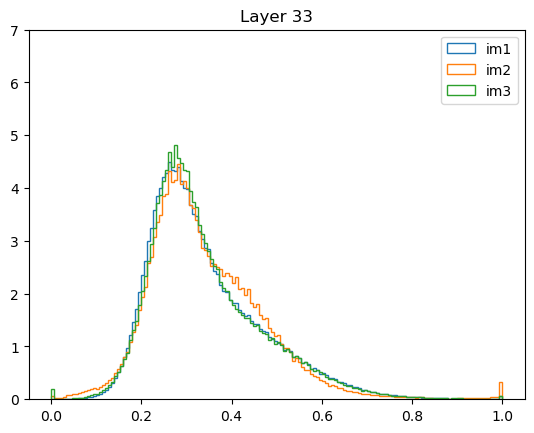

<Figure size 640x480 with 0 Axes>

In [140]:
plt.figure()
bins = 150
plt.hist(flattened_data1,bins=bins,histtype='step',density=True,label='im1')

plt.hist(flattened_data2,bins=bins,histtype='step',density=True,label='im2')

plt.hist(flattened_data3,bins=bins,histtype='step',density=True,label='im3')

plt.title(f'Layer {22+j}')
plt.ylim(0,7)
plt.legend()
plt.figure()

In [142]:
print(np.mean(flattened_data1))
print(np.mean(flattened_data2))
print(np.mean(flattened_data3))

0.3418279141576013
0.342298493114995
0.3418418188461492


In [ ]:
big_image_size = (8200, 6700)  
DataL = DataLoader(data1,batch_size = 1)

big_image = np.zeros(big_image_size)

for (patch, ts, idx) in (DataL):
    idx = idx.view(500,2)
    x_indices, y_indices = idx[:,0].numpy(),idx[:,1].numpy()
    
    for i, y in enumerate(y_indices):
        big_image[x_indices, y] = patch[0][0].numpy()[:,i]


In [ ]:
plt.imshow(big_image)
plt.colorbar()

In [ ]:
big_image_size = (16000, 10000)  
DataL = DataLoader(data2,batch_size = 1)

big_image2 = np.zeros(big_image_size)

for (patch, ts, idx) in (DataL):
    idx = idx.view(500,2)
    x_indices, y_indices = idx[:,0].numpy(),idx[:,1].numpy()
    
    for i, y in enumerate(y_indices):
        big_image2[x_indices, y] = patch[0][0].numpy()[:,i]


In [ ]:
plt.imshow(big_image2)
plt.colorbar()

<Figure size 640x480 with 0 Axes>

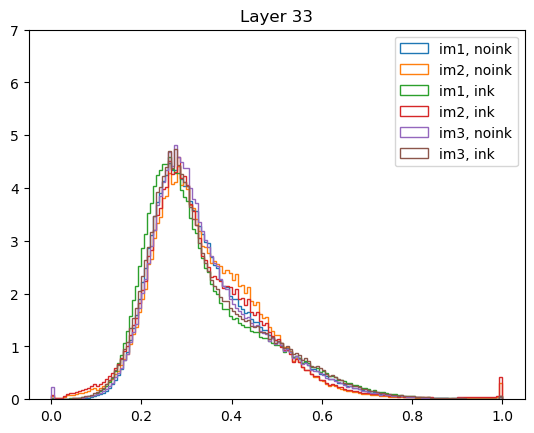

<Figure size 640x480 with 0 Axes>

In [143]:
bins = 150
plt.hist((flattened_data1[flattened_labels1 == 0]),bins=bins,histtype='step',density=True,label='im1, noink')
plt.hist((flattened_data2[flattened_labels2 == 0]),bins=bins,histtype='step',density=True,label='im2, noink') 

plt.hist((flattened_data1[flattened_labels1 == 1]),bins=bins,histtype='step',density=True,label='im1, ink')
plt.hist((flattened_data2[flattened_labels2 == 1]),bins=bins,histtype='step',density=True,label='im2, ink') 

plt.hist((flattened_data3[flattened_labels3 == 0]),bins=bins,histtype='step',density=True,label='im3, noink')
plt.hist((flattened_data3[flattened_labels3 == 1]),bins=bins,histtype='step',density=True,label='im3, ink') 

plt.title(f'Layer {22+j}')
plt.ylim(0,7)
plt.legend()
plt.figure()


In [ ]:
calibrator1[7]

<Figure size 640x480 with 0 Axes>

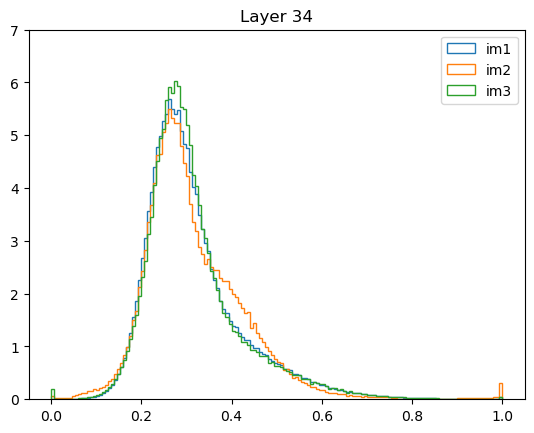

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure()
bins = 150
plt.hist(flattened_data1,bins=bins,histtype='step',density=True,label='im1')

plt.hist(flattened_data2,bins=bins,histtype='step',density=True,label='im2')

plt.hist(flattened_data3,bins=bins,histtype='step',density=True,label='im3')

plt.title(f'Layer {22+j}')
plt.ylim(0,7)
plt.legend()
plt.figure()

In [ ]:
print(np.mean(flattened_data1),np.std(flattened_data1))
print(np.mean(flattened_data2),np.std(flattened_data2))
print(np.mean(flattened_data3),np.std(flattened_data3))

In [ ]:
diff1 = 0.4468871853247354-0.4003519961695453
diff2 = 0.4468871853247354-0.4420488982008946

std1 = (0.14775991989824996/0.11539712483335136)
std2 = (0.14775991989824996/0.12360374909684443)

In [ ]:
data3 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-challenge-ink-detection/train/3"\
    ,nucleus_shape = (500,500),hull_size=(500,500), z_start=0\
    , z_end=64,boundarysize=100,compress_depth=[65])

# Filtering

#### Gaussian filter

In [ ]:
import numpy as np
from scipy import ndimage
sigma = (3.0, 2.0, 2.0)  

In [ ]:
bins = 10
plt.hist(flattened_data1,bins = bins)
plt.hist(flattened_data2,bins = bins)

In [ ]:
class PictureBuilder:
    def __init__(self,snippet_width=100,snippet_height=100):
        self.full_width = 6452
        self.full_height = 8298
    
        self.snippet_width = snippet_width
        self.snippet_height = snippet_height

        self.full_picture = np.zeros((self.full_height, self.full_width))
        

    def __call__(self,indx_matrix,snippet_matrix):
        height = indx_matrix[0]
        width = indx_matrix[1]
        temp = insert_snippet(self.full_picture,height,width,self.snippet_height\
                       ,self.snippet_width,snippet_matrix)
        self.full_picture = temp
        
    
    def _get(self):
        return self.full_picture


def insert_snippet(full_picture,height,width,sheight,swidth,smatrix):
    for i in range(sheight):
        for j in range(swidth):
            full_picture[height[i],width[j]] = smatrix[i,j]
    return full_picture

In [ ]:
picture = PictureBuilder(snippet_width=100,snippet_height=100)
pics_loader = DataLoader(data1, batch_size=1)
for  i, (ds, ts, idx_arr) in tqdm(enumerate(pics_loader)):
    datl = flattened_data1[i].to(torch.double).numpy()
    picture(idx.T, datl)

In [ ]:
plt.imshow(picture._get())

In [ ]:
bins = 200
plt.hist(dict1['x1'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(dict2['x1'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.ylim(0,30)

bins = 200
plt.hist(dict1['x2'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(dict2['x2'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()

In [ ]:
mask1 = (dict1['x1'] >= 0.1) & (dict1['x1'] <= 0.9)
mask2 = (dict2['x1'] >= 0.1) & (dict2['x1'] <= 0.9)
print((np.median(dict1['x1'][mask1])-np.median(dict2['x1'][mask2])))



In [ ]:
from torch.utils.data import DataLoader

datasets =[data1,data2,data3]
ink_dict = {}
noink_dict = {}

inktf_dict = {}
noinktf_dict = {}

for idx, data in enumerate(datasets):
    DataL = DataLoader(data,batch_size = 1)
    flattened_data1 = np.array([]) 
    flattened_data2 = np.array([])
    flattened_data3 = np.array([]) 
    flattened_data4 = np.array([])
    
    for  (ds, ts) in DataL:
        ds = ds.view(10,500,500)
        ds = ds.to(torch.float32)
        flat = ds[4,:,:].flatten()
        flat_ts = ts.flatten()

        
        flattened_data1 = np.append(flattened_data1,flat[flat_ts == 0])
        flattened_data2 = np.append(flattened_data2,flat[flat_ts == 1])        
        filtered_arr =  ndimage.gaussian_filter(ds,sigma=sigma)
        flat_filt = filtered_arr[4,:,:].flatten()
        flattened_data3 = np.append(flattened_data3, flat_filt[flat_ts == 0])
        flattened_data4 = np.append(flattened_data4, flat_filt[flat_ts == 1])
        
    noink_dict[f'x{idx+1}'] = flattened_data1
    ink_dict[f'x{idx+1}'] = flattened_data2
    noinktf_dict[f'x{idx+1}'] = flattened_data3
    inktf_dict[f'x{idx+1}'] = flattened_data4
    
    print("Done",idx+1)
        



In [ ]:
bins = 200
plt.hist(noink_dict['x1'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(ink_dict['x1'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.title('Non-transformed')

plt.figure()

plt.hist(noinktf_dict['x1'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(inktf_dict['x1'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.title('Transformed')



plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.figure()


In [ ]:
bins = 200
plt.hist(noink_dict['x2'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(ink_dict['x2'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.title('Non-transformed')

plt.figure()

plt.hist(noinktf_dict['x2'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(inktf_dict['x2'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.title('Transformed')



plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.figure()

In [ ]:
bins = 200
plt.hist(noink_dict['x3'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(ink_dict['x3'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.title('Non-transformed')

plt.figure()

plt.hist(noinktf_dict['x3'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(inktf_dict['x3'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.title('Transformed')



plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.figure()

In [ ]:
from torch.utils.data import DataLoader

score = []
preds = []
targs = []
val_loader =DataLoader(data1, batch_size = 1)
for data, target in tqdm((val_loader)):
    output = torch.tensor(np.ones((target.shape[0],100*100)))
    target = target.view(target.shape[0],100*100)
    target = target.to(output.dtype)
    score.append(nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))(output, target).item())
    preds.append(torch.round(nn.Sigmoid()(output)).detach().cpu().numpy())
    targs.append(target.detach().cpu().numpy())

print(np.mean(score))

In [ ]:
class Fscore:
    def __init__(self):
        self.epsilon = 1e-7
        self.tp = 0
        self.fp = 0
        self.fn = 0
    
    def accumulate(self, y_true, y_pred):
        # Flatten the input arrays to 1D
        y_true = np.ravel(y_true)
        y_pred = np.ravel(y_pred)
        
        # Update true positives, false positives, and false negatives
        self.tp += np.sum((y_true == 1) & (y_pred == 1))
        self.fp += np.sum((y_true == 0) & (y_pred == 1))
        self.fn += np.sum((y_true == 1) & (y_pred == 0))
    
    def get_score(self, beta=1):
       # Calculate precision, recall, and F-score
        precision = self.tp / (self.tp + self.fp + self.epsilon)
        recall = self.tp / (self.tp + self.fn + self.epsilon)
        f_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + self.epsilon)
    
        return f_score

In [ ]:
score = Fscore()
for p,t in zip(preds,targs):
     score.accumulate(t,p)
        
print(score.get_score(beta=0.5))

#### Median filter

In [ ]:
window_size = (3, 3, 3)
kernel = np.ones(window_size)
from skimage import filters

In [ ]:
from torch.utils.data import DataLoader

datasets =[data1,data2,data3]
ink_dict2 = {}
noink_dict2 = {}

inktf_dict2 = {}
noinktf_dict2 = {}

for idx, data in enumerate(datasets):
    
    DataL = DataLoader(data,batch_size = 1)
    flattened_data1 = np.array([]) 
    flattened_data2 = np.array([])
    flattened_data3 = np.array([]) 
    flattened_data4 = np.array([])
    
    for  (ds, ts) in DataL:
        ds = ds.view(10,500,500)
        ds = ds.to(torch.float32)
        flat = ds[4,:,:].flatten()
        flat_ts = ts.flatten()

        
        flattened_data1 = np.append(flattened_data1,flat[flat_ts == 0])
        flattened_data2 = np.append(flattened_data2,flat[flat_ts == 1])        
        filtered_arr =  ndimage.median_filter(ds, size=window_size)
        flat_filt = filtered_arr[4,:,:].flatten()
        flattened_data3 = np.append(flattened_data3, flat_filt[flat_ts == 0])
        flattened_data4 = np.append(flattened_data4, flat_filt[flat_ts == 1])
        
    noink_dict2[f'x{idx+1}'] = flattened_data1
    ink_dict2[f'x{idx+1}'] = flattened_data2
    noinktf_dict2[f'x{idx+1}'] = flattened_data3
    inktf_dict2[f'x{idx+1}'] = flattened_data4
    
    print("Done",idx+1)
        



In [ ]:
bins = 200
plt.hist(noink_dict['x1'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(ink_dict['x1'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.title('Non-transformed')

plt.figure()

plt.hist(noinktf_dict['x1'],bins=bins,histtype='step',density=True,label='noink')
plt.hist(inktf_dict['x1'],bins=bins,histtype='step',density=True,label='ink')
plt.legend()
plt.title('Transformed')



plt.ylim(0,10)
plt.xlim(0.1,0.7)
plt.figure()


In [ ]:
print(len(np.array(data_dict['x2'])))

In [ ]:
snip1 = [data_dict['x1'][i] for i in range(len(data_dict['x1'])) if 0.6> data_dict['x1'][i] > 0.2]
snip2 = [data_dict['x2'][i] for i in range(len(data_dict['x2'])) if 0.6> data_dict['x2'][i] > 0.2]
snip3 = [data_dict['x3'][i] for i in range(len(data_dict['x3'])) if 0.6>data_dict['x3'][i] > 0.2]


In [ ]:
means = np.array([np.mean(snip1),np.mean(snip2),np.mean(snip3)])
stds = np.array([np.std(snip1),np.std(snip2),np.std(snip3)])


# Model

In [ ]:
def calibrate1(x):
    mask = (x >= 0.1) & (x <= 0.9)  # Create a boolean mask for values within the specified range
    scaled_x = np.copy(x)  # Create a copy of the input array
    scaled_x[mask] = (0.01581065 / 0.01783962) * x[mask] + (0.378124 - 0.35546485)  # Apply calibration within the range
    return scaled_x

def calibrate2(x):
    mask = (x >= 0.1) & (x <= 0.9)  # Create a boolean mask for values within the specified range
    scaled_x = np.copy(x)  # Create a copy of the input array
    scaled_x[mask] = (0.01581065/0.01669826) * x[mask] -0.012  # Apply calibration within the range
    return scaled_x

In [ ]:
data1 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-smaller-images/train/1"\
    ,nucleus_shape = (8,8),hull_size=(24,24), z_start=15
    , z_end=35,give_indx=True,boundarysize = 100)

In [ ]:
data2 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-smaller-images/train/2"\
    ,nucleus_shape = (8,8),hull_size=(24,24), z_start=25
    , z_end=35,give_indx=True,boundarysize = 100,calibrator='calibrate1')

In [ ]:
data3 = VesuviusTrainData(
    dir_path="/kaggle/input/vesuvius-smaller-images/train/3"\
    ,nucleus_shape = (8,8),hull_size=(24,24), z_start=25
    , z_end=35,give_indx=True,calibrator='calibrate2')

In [ ]:
from torch.utils.data import ConcatDataset
merged_dataset = ConcatDataset([data1, data2])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#import torch_xla
#import torch_xla.core.xla_model as xm
#device = xm.xla_device()

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc = nn.Linear(576, 64)
        
        self.saved_loss = []
        self.saved_epoch = []
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool3d(x, kernel_size=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool3d(x, kernel_size=2)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool3d(x, kernel_size=2)
        x = x.view(x.size(0), -1)  
        x = self.fc(x)
        return x
    


    def fit(self, train_data,optimizer, criterion, num_epochs,verbose=False): 
        train_loader = DataLoader(train_data, batch_size = 512, shuffle=True)
        for epoch in range(num_epochs):
            loss_list = []
            f1_list = []
            for batch_idx, (data, target,idxs) in tqdm(enumerate(train_loader)):
                inputs = data.view(data.shape[0],1, *data.shape[1:])
                inputs = inputs.to(device)
                output = (self(inputs))
                target = target.to(device)
                target = target.to(torch.float)
                optimizer.zero_grad()
                loss = criterion(output, target.view(target.shape[0], -1))
                loss_list.append(loss.item())
                loss.backward()
                optimizer.step()
            if verbose == True:
                epoch_loss = np.mean(loss_list)
                self.save_loss(epoch_loss,epoch)
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
            
                
    def save_loss(self,epoch_loss,epoch):
        self.saved_loss.append(epoch_loss)
        if len(self.saved_epoch) != 0:
            if self.saved_epoch[-1] > epoch:
                self.saved_epoch.append(self.saved_epoch[-1]+1)
            else:
                 self.saved_epoch.append(epoch)
        else:
            self.saved_epoch.append(epoch)

In [ ]:
model = CNN3D()
model.load_state_dict(torch.load("/kaggle/input/3dweights/new_3dweights.pth", map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))
model.to(device)

num_epochs = 3
#model.fit(merged_dataset,optimizer,criterion,num_epochs,verbose = True)
#torch.save(model.state_dict(), 'new_3dweights.pth')


In [ ]:
num_epochs = 2
model.fit(merged_dataset,optimizer,criterion,num_epochs,verbose = True)

In [ ]:
torch.save(model.state_dict(), '3dweights.pth')

In [ ]:
score = []
val_loader =DataLoader(data3, batch_size = 512)
for data, target,idxs in tqdm((val_loader)):
    output = model(data.view(data.shape[0],1,*data.shape[1:]).to(device))
    target = target.to(device).view(target.shape[0],64)
    target = target.to(output.dtype)
    score.append(nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))(output, target).item())

print(np.mean(score))

In [ ]:
0.7422968658614996

In [ ]:
class PictureBuilder:
    def __init__(self,snippet_width=8,snippet_height=8):
        self.full_width = 6452
        self.full_height = 8298
    
        self.snippet_width = snippet_width
        self.snippet_height = snippet_height

        self.full_picture = np.zeros((self.full_height, self.full_width))
        

    def __call__(self,indx_matrix,snippet_matrix):
        height = indx_matrix[0]
        width = indx_matrix[1]
        temp = insert_snippet(self.full_picture,height,width,self.snippet_height\
                       ,self.snippet_width,snippet_matrix)
        self.full_picture = temp
        
    
    def _get(self):
        return self.full_picture

@numba.njit()
def insert_snippet(full_picture,height,width,sheight,swidth,smatrix):
    for i in range(sheight):
        for j in range(swidth):
            full_picture[height[i],width[j]] = smatrix[i,j]
    return full_picture

In [ ]:
picture = PictureBuilder(snippet_width=8,snippet_height=8)
pics_loader = DataLoader(data3, batch_size=1)
for batch_idx, (x_data, target, indx_arr) in tqdm(enumerate(pics_loader)):
    x_data = x_data.view(1,*x_data.shape)
    x_data = torch.tensor((x_data).to(device))
    pred =  torch.sigmoid(model(x_data))
    pred_cpu = pred.detach().cpu().numpy()
    picture(indx_arr[0, :].T.numpy(), pred_cpu.reshape(8, 8))
    if batch_idx > 400000:
        break
        

In [ ]:
plt.imshow(np.round(picture._get()))

In [ ]:
def f_score(y_true, y_pred, beta=1):
    # Flatten the tensors
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    # Calculate true positives, false positives, and false negatives
    true_positives = (y_true * y_pred).sum()
    false_positives = ((1 - y_true) * y_pred).sum()
    false_negatives = (y_true * (1 - y_pred)).sum()

    # Calculate precision, recall, and F-score
    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-7)

    return f_score

In [ ]:
res = [] 
pics_loader = DataLoader(data3, batch_size=150,shuffle=True)
for batch_idx, (x_data, target, idxs) in tqdm(enumerate(pics_loader)):
    output = model(x_data.view(x_data.shape[0],1,*x_data.shape[1:]).to(device))
    target = target.to(device).view(target.shape[0],64)
    target = target.to(output.dtype)
    res.append(f_score(target,output).item())
    

In [ ]:
print(np.mean(res))

In [ ]:
np.mean(torch.tensor(res).detach().cpu().numpy())